# **AML Challenge: Model Stitching**

In [2]:
# @title
from PIL import Image
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms

from sentence_transformers import SentenceTransformer, util
from diffusers import AutoencoderKL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

## **Downloading the Text Encoder**

In [4]:
print("🫁 Downloading the model...")
text_encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

🫁 Downloading the model...


### **Demo for the Text Encoder:**

In [5]:
text = "A cat is hiding under the table"

# We obtain the "embedding vector" using the encode() function:
emb = text_encoder.encode(text, convert_to_tensor=True, show_progress_bar=False)

# This is only for clarity:
preview = emb.tolist()[:3] + ["..."] + emb.tolist()[-3:]
print(f"The embedding looks like this: {preview}")

# This is the shape of our embedding:
print(f"The shape of the embedding is: {emb.shape}")

The embedding looks like this: [0.06564974039793015, 0.07378216087818146, -0.029973773285746574, '...', -0.007066953461617231, 0.007970691658556461, 0.10162461549043655]
The shape of the embedding is: torch.Size([384])


## **Downloading the VAE**

In [6]:
print("🫁 Downloading VAE from Hugging Face...")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)

🫁 Downloading VAE from Hugging Face...


### **Demo for the VAE:**

In [7]:
IMG_URL = "https://images.unsplash.com/photo-1574144611937-0df059b5ef3e?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=764"
img = Image.open(urlopen(IMG_URL)).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((256, 256)), # --> keep this size fixed
    # The VAE works also for 512x512, but it will require more compute
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
img_tensor = preprocess(img).unsqueeze(0).to(device)


# Encode --> latent
with torch.no_grad():
    latents = vae.encode(img_tensor).latent_dist.sample() * 0.18215
print("Latent shape:", latents.shape)

# Decode --> reconstruct
with torch.no_grad():
    recon = vae.decode(latents / 0.18215).sample

recon = (recon.clamp(-1, 1) + 1) / 2
recon_img = transforms.ToPILImage()(recon.squeeze().cpu())

Latent shape: torch.Size([1, 4, 32, 32])


In [8]:
preprocess

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [9]:
img_tensor.shape

torch.Size([1, 3, 256, 256])

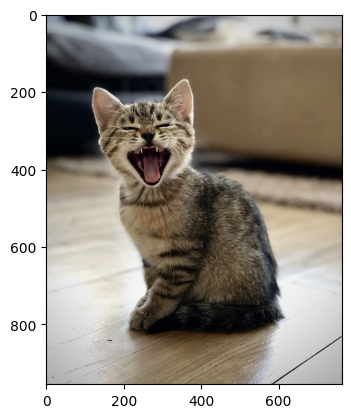

In [10]:
plt.imshow(img)

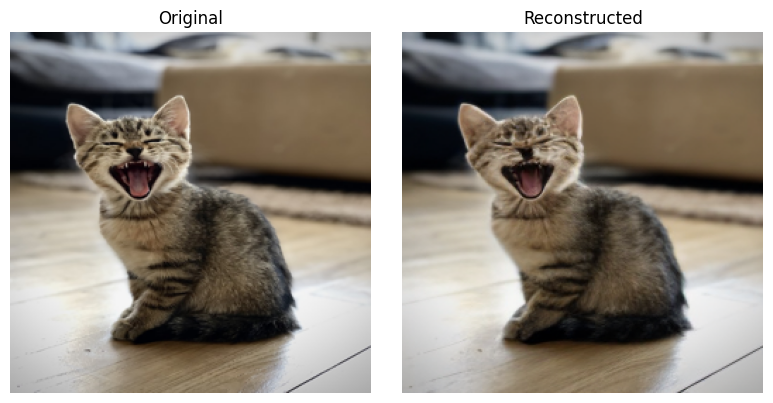

In [11]:
# Visualize input vs output:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img.resize((256, 256)))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(recon_img)
axes[1].set_title("Reconstructed")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#**Frankenstein Model:**

In [12]:
class Translator(nn.Module):
    """
    This will be the Translator Model you have to design for the challenge.
    You have (almost) complete freedom on this. Your creativity will be rewarded.

    Some ideas might be:
    - Zero shot stitching (see https://arxiv.org/pdf/2209.15430)
    - Linear, Affine, Orthognal solutions (see https://arxiv.org/pdf/2311.00664)
    - Diffusion Priors (see https://arxiv.org/pdf/2204.06125)
    - Flow Matching (see https://arxiv.org/pdf/2412.15213)
    - CKA / Procrustes Analysis
    - Adversarial Trainings
    - AutoEncoding Solutions
    """

    def __init__(self):
        super().__init__()
        # Here is where *you* come into play:
        self.fc = nn.Linear(384, 4 * 32 * 32)
        # This is the most trivial thing you can do (spoiler: it doesn't work)

    def forward(self, x):
        x = self.fc(x)
        return x.view(1, 4, 32, 32)

translator = Translator().to(device)
translator.eval()

Translator(
  (fc): Linear(in_features=384, out_features=4096, bias=True)
)

Prompt: Frankestein's Monster writing code on Google Colab
Text embedding shape: torch.Size([384])
Translated latent shape: torch.Size([1, 4, 32, 32])




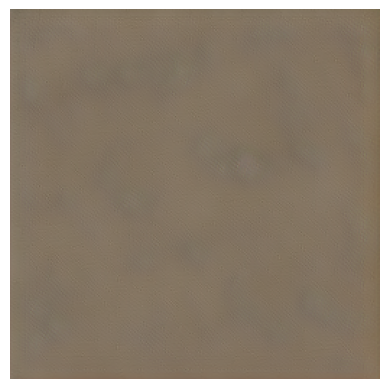

In [13]:
# Part 1: encoding the text prompt
text = "Frankestein's Monster writing code on Google Colab"
print(f"Prompt: {text}")
emb = text_encoder.encode(text, convert_to_tensor=True).to(device)
print("Text embedding shape:", emb.shape)

# Part 2: translating the embedding
with torch.no_grad():
    latent = translator(emb)
print(f"Translated latent shape: {latent.shape}\n\n")

# Part 3: feed the VAE with the translation
with torch.no_grad():
    recon = vae.decode(latent / 0.18215).sample

# Part 4: visualizing the output
recon = (recon.clamp(-1, 1) + 1) / 2
recon_img = transforms.ToPILImage()(recon.squeeze().cpu())

plt.imshow(recon_img)
plt.axis("off")
plt.show()